In [1]:
!gdown 1gDNUJYw-aUos0NTxTjrJTYenAFA_5jNs

Downloading...
From: https://drive.google.com/uc?id=1gDNUJYw-aUos0NTxTjrJTYenAFA_5jNs
To: /content/hvac_valve_data.csv
100% 15.3k/15.3k [00:00<00:00, 41.3MB/s]


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/hvac_valve_data.csv')

# Remove the 'day' column
data = data.drop(columns=['Day'])

# Display first five rows of the dataset
data.head()

,Hour,Indoor Temperature,Outdoor Temperature,Setpoint Temperature,3-Way Valve Position
0,7,20.790136,28.797435,22,0.0
1,9,20.052228,28.673260,22,0.0
2,11,24.408804,35.449545,22,1.0
3,13,25.523063,41.765079,22,1.0
4,15,24.446614,36.021703,22,1.0


#data visualization

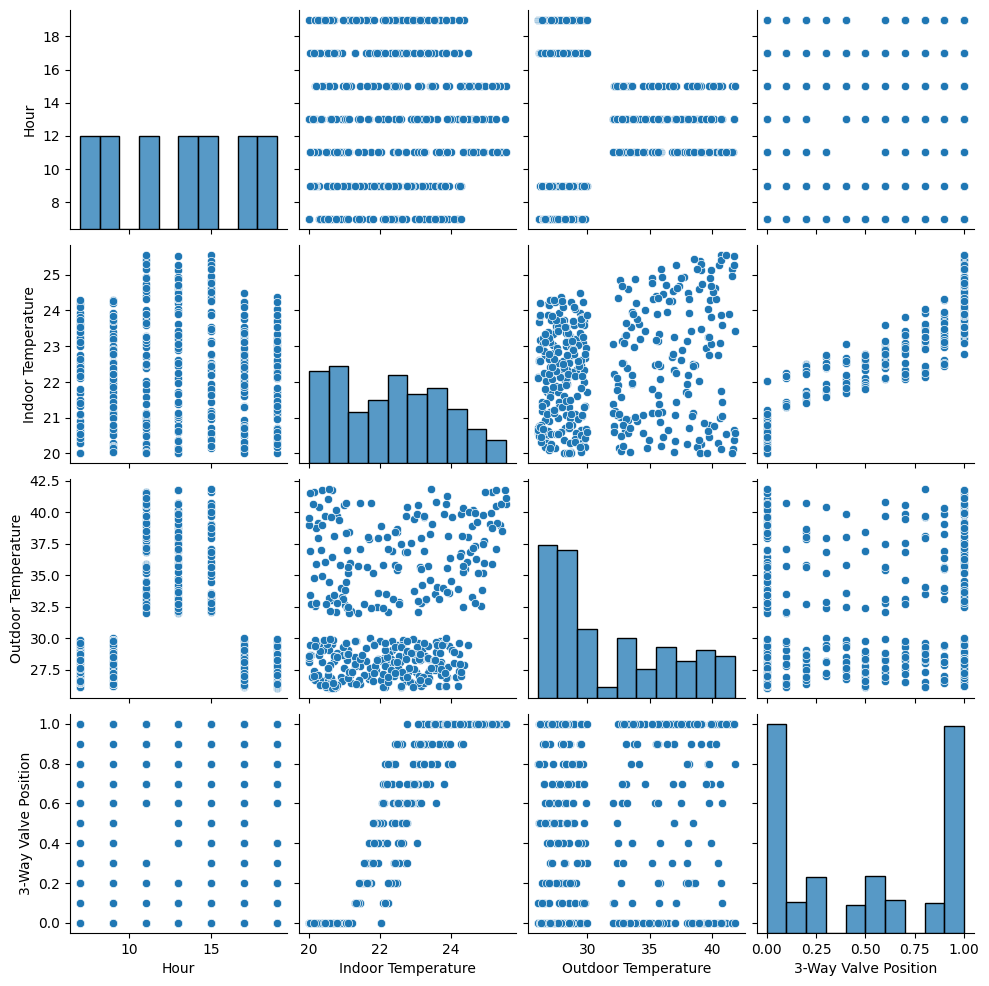

In [3]:
# Pair plot
data1 = data.drop(columns=['Setpoint Temperature'])
sns.pairplot(data1)
plt.show()

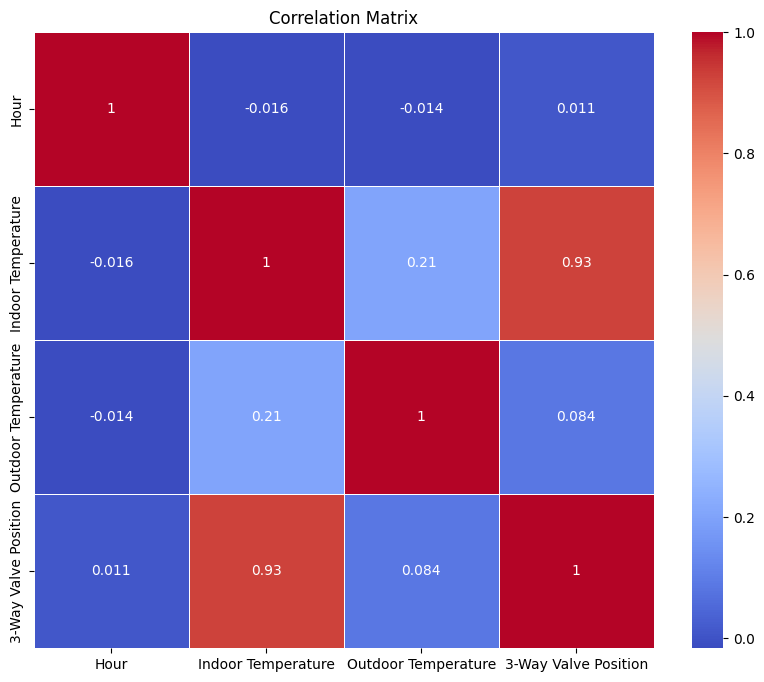

In [4]:
# Compute the correlation matrix
correlation_matrix = data1.corr()
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

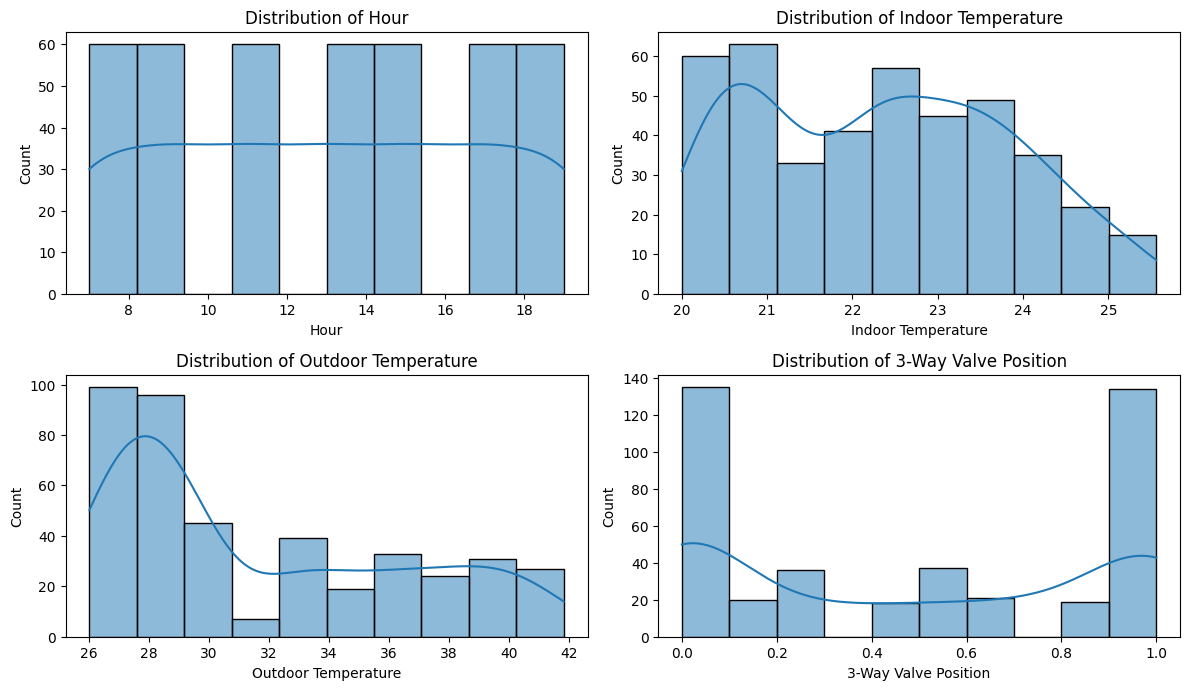

In [5]:
plt.figure(figsize=(12, 10))
for i, column in enumerate(data1.columns, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

#HVACEnvironment

In [33]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

class HVACEnvironment:
    def __init__(self, data, timestep=1, sim_steps=5):
        self.data = data
        self.current_index = 0
        self.timestep = timestep
        self.sim_steps = sim_steps
        self.current_temp = None

    def reset(self):
        self.current_index = 0
        row = self.data.iloc[self.current_index]
        self.current_temp = row['Indoor Temperature']
        return (self.current_temp, row['Outdoor Temperature'], row['Hour'])

    def step(self, action):
        row = self.data.iloc[self.current_index]
        outdoor_temp = row['Outdoor Temperature']
        hour = row['Hour']

        heat_transfer_coefficient = 0.01
        for _ in range(self.sim_steps):
            temp_change = (outdoor_temp - self.current_temp) * heat_transfer_coefficient * action
            self.current_temp += temp_change

        energy = abs(row['Setpoint Temperature'] - self.current_temp) * action + abs(row['Setpoint Temperature'] - self.current_temp)
        reward = -energy

        self.current_index += self.timestep
        if self.current_index >= len(self.data):
            done = True
            next_state = (self.current_temp, outdoor_temp, hour)
        else:
            next_row = self.data.iloc[self.current_index]
            next_state = (self.current_temp, next_row['Outdoor Temperature'], next_row['Hour'])
            done = False

        return next_state, reward, done

#QLearningAgent

In [16]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.995):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.q_table = {}
        self.cumulative_rewards = []
        self.actions = np.arange(0, 1.1, 0.1)

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def update_q_value(self, state, action, reward, next_state):
        best_next_action = max(self.actions, key=lambda x: self.get_q_value(next_state, x))
        td_target = reward + self.discount_factor * self.get_q_value(next_state, best_next_action)
        td_error = td_target - self.get_q_value(state, action)
        new_q_value = self.get_q_value(state, action) + self.learning_rate * td_error
        self.q_table[(state, action)] = new_q_value

    def choose_action(self, state):
        if random.random() < self.exploration_rate:
            return random.choice(self.actions)
        else:
            return max(self.actions, key=lambda x: self.get_q_value(state, x))

    def train(self, episodes, max_steps_per_episode):
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            for step in range(max_steps_per_episode):
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_value(state, action, reward, next_state)
                state = next_state
                total_reward += reward

                if done:
                    break

            self.exploration_rate *= self.exploration_decay
            self.cumulative_rewards.append(total_reward)
            print(f"Episode {episode + 1}: Total Reward: {total_reward}, Exploration Rate: {self.exploration_rate}")

    def plot_cumulative_rewards(self):
        plt.plot(self.cumulative_rewards)
        plt.title('Cumulative Reward during Training')
        plt.xlabel('Episode')
        plt.ylabel('Cumulative Reward')
        plt.grid(True)
        plt.show()

    def play(self, episodes, max_steps_per_episode):
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            for step in range(max_steps_per_episode):
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                state = next_state
                total_reward += reward

                if done:
                    break

            print(f"Episode {episode + 1}: Total Reward: {total_reward}")


In [21]:
train_data = data[:len(data) // 2]
test_data = data[len(data) // 2:]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

Streaming output truncated to the last 5000 lines.
Episode 3001: Total Reward: -19.52620818217699, Exploration Rate: 2.931334084960731e-07
Episode 3002: Total Reward: -16.554818065215514, Exploration Rate: 2.9166774145359274e-07
Episode 3003: Total Reward: -4.287164372691633, Exploration Rate: 2.9020940274632476e-07
Episode 3004: Total Reward: -12.141020360413755, Exploration Rate: 2.8875835573259315e-07
Episode 3005: Total Reward: -25.42966655837203, Exploration Rate: 2.873145639539302e-07
Episode 3006: Total Reward: -5.071330286621466, Exploration Rate: 2.858779911341605e-07
Episode 3007: Total Reward: -18.474858195577426, Exploration Rate: 2.8444860117848974e-07
Episode 3008: Total Reward: -21.771529324811343, Exploration Rate: 2.830263581725973e-07
Episode 3009: Total Reward: -3.120994691531197, Exploration Rate: 2.816112263817343e-07
Episode 3010: Total Reward: -8.599179795825743, Exploration Rate: 2.8020317024982564e-07
Episode 3011: Total Reward: -5.300904680181331, Exploration 

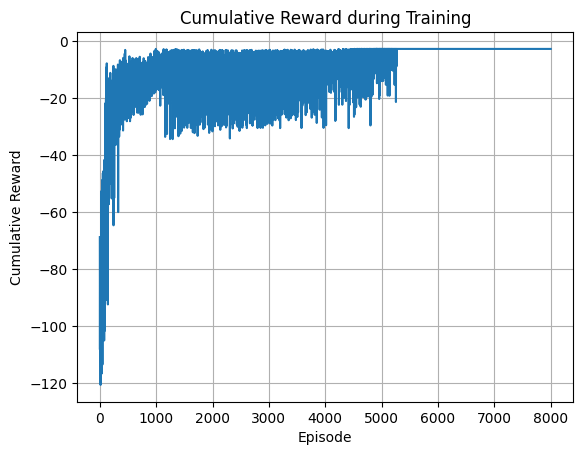

Episode 1: Total Reward: -2.8211151688657004
Episode 2: Total Reward: -2.8211151688657004
Episode 3: Total Reward: -2.8211151688657004
Episode 4: Total Reward: -2.8211151688657004
Episode 5: Total Reward: -2.8211151688657004
Episode 6: Total Reward: -2.8211151688657004
Episode 7: Total Reward: -2.8211151688657004
Episode 8: Total Reward: -2.8211151688657004
Episode 9: Total Reward: -2.8211151688657004
Episode 10: Total Reward: -2.8211151688657004


In [24]:
if __name__ == "__main__":

    # Create the environment
    env = HVACEnvironment(data)

    # Create the Q-learning agent
    agent = QLearningAgent(env)

    # Training the agent
    agent.train(episodes=8000, max_steps_per_episode=30)

    # Plot cumulative rewards and average rewards
    agent.plot_cumulative_rewards()

    # Create the environment for testing
    test_env = HVACEnvironment(test_data)

    # Create the Q-learning agent with the same environment
    test_agent = QLearningAgent(test_env)

    # Playing the environment with the trained agent
    agent.play(episodes=10, max_steps_per_episode=50)

#gridsearch

In [41]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

class HVACEnvironment:
    def __init__(self, data, timestep=1, sim_steps=5):
        self.data = data
        self.current_index = 0
        self.timestep = timestep
        self.sim_steps = sim_steps
        self.current_temp = None

    def reset(self):
        self.current_index = 0
        row = self.data.iloc[self.current_index]
        self.current_temp = row['Indoor Temperature']
        return (self.current_temp, row['Outdoor Temperature'], row['Hour'])

    def step(self, action):
        row = self.data.iloc[self.current_index]
        outdoor_temp = row['Outdoor Temperature']
        hour = row['Hour']

        heat_transfer_coefficient = 0.01
        for _ in range(self.sim_steps):
            temp_change = (outdoor_temp - self.current_temp) * heat_transfer_coefficient * action
            self.current_temp += temp_change

        energy = abs(row['Setpoint Temperature'] - self.current_temp) * action + abs(row['Setpoint Temperature'] - self.current_temp)
        reward = -energy

        self.current_index += self.timestep
        if self.current_index >= len(self.data):
            done = True
            next_state = (self.current_temp, outdoor_temp, hour)
        else:
            next_row = self.data.iloc[self.current_index]
            next_state = (self.current_temp, next_row['Outdoor Temperature'], next_row['Hour'])
            done = False

        return next_state, reward, done

class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.995):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.q_table = {}
        self.cumulative_rewards = []
        self.actions = np.arange(0, 1.1, 0.1)

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def update_q_value(self, state, action, reward, next_state):
        best_next_action = max(self.actions, key=lambda x: self.get_q_value(next_state, x))
        td_target = reward + self.discount_factor * self.get_q_value(next_state, best_next_action)
        td_error = td_target - self.get_q_value(state, action)
        new_q_value = self.get_q_value(state, action) + self.learning_rate * td_error
        self.q_table[(state, action)] = new_q_value

    def choose_action(self, state):
        if random.random() < self.exploration_rate:
            return random.choice(self.actions)
        else:
            return max(self.actions, key=lambda x: self.get_q_value(state, x))

    def train(self, episodes, max_steps_per_episode):
        self.cumulative_rewards = []
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            for step in range(max_steps_per_episode):
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_value(state, action, reward, next_state)
                state = next_state
                total_reward += reward

                if done:
                    break

            self.exploration_rate *= self.exploration_decay
            self.cumulative_rewards.append(total_reward)

        return np.mean(self.cumulative_rewards)  # Return the average reward for this set of hyperparameters

    def plot_cumulative_rewards(self):
        plt.plot(self.cumulative_rewards)
        plt.title('Cumulative Reward during Training')
        plt.xlabel('Episode')
        plt.ylabel('Cumulative Reward')
        plt.grid(True)
        plt.show()

# Define parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'discount_factor': [0.9, 0.95, 0.99],
    'exploration_rate': [1.0, 0.8, 0.5],
    'exploration_decay': [0.995, 0.99, 0.9]
}

best_score = -float('inf')
best_params = {}

for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")
    env = HVACEnvironment(data)
    agent = QLearningAgent(env, **params)
    avg_reward = agent.train(episodes=200, max_steps_per_episode=30)  # Adjust episodes and steps as needed

    if avg_reward > best_score:
        best_score = avg_reward
        best_params = params

    print(f"Average Reward: {avg_reward}")

print(f"Best parameters found: {best_params}")


Testing parameters: {'discount_factor': 0.9, 'exploration_decay': 0.995, 'exploration_rate': 1.0, 'learning_rate': 0.01}
Average Reward: -55.83377611753056
Testing parameters: {'discount_factor': 0.9, 'exploration_decay': 0.995, 'exploration_rate': 1.0, 'learning_rate': 0.1}
Average Reward: -56.97717543854559
Testing parameters: {'discount_factor': 0.9, 'exploration_decay': 0.995, 'exploration_rate': 1.0, 'learning_rate': 0.5}
Average Reward: -56.331348751184166
Testing parameters: {'discount_factor': 0.9, 'exploration_decay': 0.995, 'exploration_rate': 0.8, 'learning_rate': 0.01}
Average Reward: -43.89599231180002
Testing parameters: {'discount_factor': 0.9, 'exploration_decay': 0.995, 'exploration_rate': 0.8, 'learning_rate': 0.1}
Average Reward: -42.48994197592423
Testing parameters: {'discount_factor': 0.9, 'exploration_decay': 0.995, 'exploration_rate': 0.8, 'learning_rate': 0.5}
Average Reward: -43.273863330417996
Testing parameters: {'discount_factor': 0.9, 'exploration_decay': 

In [42]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.5, discount_factor=0.95, exploration_rate=0.5, exploration_decay=0.99):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.q_table = {}
        self.cumulative_rewards = []
        self.actions = np.arange(0, 1.1, 0.1)

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def update_q_value(self, state, action, reward, next_state):
        best_next_action = max(self.actions, key=lambda x: self.get_q_value(next_state, x))
        td_target = reward + self.discount_factor * self.get_q_value(next_state, best_next_action)
        td_error = td_target - self.get_q_value(state, action)
        new_q_value = self.get_q_value(state, action) + self.learning_rate * td_error
        self.q_table[(state, action)] = new_q_value

    def choose_action(self, state):
        if random.random() < self.exploration_rate:
            return random.choice(self.actions)
        else:
            return max(self.actions, key=lambda x: self.get_q_value(state, x))

    def train(self, episodes, max_steps_per_episode):
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            for step in range(max_steps_per_episode):
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_value(state, action, reward, next_state)
                state = next_state
                total_reward += reward

                if done:
                    break

            self.exploration_rate *= self.exploration_decay
            self.cumulative_rewards.append(total_reward)
            print(f"Episode {episode + 1}: Total Reward: {total_reward}, Exploration Rate: {self.exploration_rate}")

    def plot_cumulative_rewards(self):
        plt.plot(self.cumulative_rewards)
        plt.title('Cumulative Reward during Training')
        plt.xlabel('Episode')
        plt.ylabel('Cumulative Reward')
        plt.grid(True)
        plt.show()

    def play(self, episodes, max_steps_per_episode):
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            for step in range(max_steps_per_episode):
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                state = next_state
                total_reward += reward

                if done:
                    break

            print(f"Episode {episode + 1}: Total Reward: {total_reward}")


Streaming output truncated to the last 5000 lines.
Episode 3001: Total Reward: -2.7134443001623203, Exploration Rate: 3.982804522340738e-14
Episode 3002: Total Reward: -2.7134443001623203, Exploration Rate: 3.9429764771173306e-14
Episode 3003: Total Reward: -2.7134443001623203, Exploration Rate: 3.903546712346157e-14
Episode 3004: Total Reward: -2.7134443001623203, Exploration Rate: 3.8645112452226954e-14
Episode 3005: Total Reward: -2.7134443001623203, Exploration Rate: 3.8258661327704685e-14
Episode 3006: Total Reward: -2.7134443001623203, Exploration Rate: 3.7876074714427637e-14
Episode 3007: Total Reward: -2.7134443001623203, Exploration Rate: 3.749731396728336e-14
Episode 3008: Total Reward: -2.7134443001623203, Exploration Rate: 3.712234082761053e-14
Episode 3009: Total Reward: -2.7134443001623203, Exploration Rate: 3.675111741933442e-14
Episode 3010: Total Reward: -2.7134443001623203, Exploration Rate: 3.6383606245141075e-14
Episode 3011: Total Reward: -2.7134443001623203, Explo

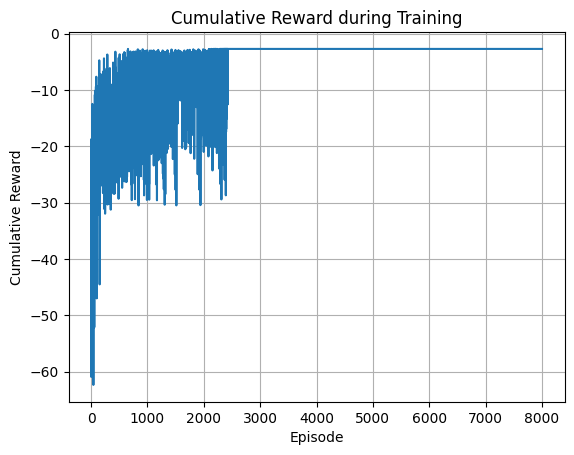

Episode 1: Total Reward: -2.8211151688657004
Episode 2: Total Reward: -2.8211151688657004
Episode 3: Total Reward: -2.8211151688657004
Episode 4: Total Reward: -2.8211151688657004
Episode 5: Total Reward: -2.8211151688657004
Episode 6: Total Reward: -2.8211151688657004
Episode 7: Total Reward: -2.8211151688657004
Episode 8: Total Reward: -2.8211151688657004
Episode 9: Total Reward: -2.8211151688657004
Episode 10: Total Reward: -2.8211151688657004


In [43]:
if __name__ == "__main__":

    # Create the environment
    env = HVACEnvironment(data)

    # Create the Q-learning agent
    agent = QLearningAgent(env)

    # Training the agent
    agent.train(episodes=8000, max_steps_per_episode=30)

    # Plot cumulative rewards and average rewards
    agent.plot_cumulative_rewards()

    # Create the environment for testing
    test_env = HVACEnvironment(test_data)

    # Create the Q-learning agent with the same environment
    test_agent = QLearningAgent(test_env)

    # Playing the environment with the trained agent
    agent.play(episodes=10, max_steps_per_episode=50)

In [46]:
def calculate_energy_consumption(env, data, agent=None, num_episodes=1):
    energy_consumption_per_episode = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_energy_consumption = 0

        while not done:
            if agent is None:
                # Control without agent (use data directly)
                action = data.iloc[env.current_index]['3-Way Valve Position']
                next_state = (data.iloc[env.current_index]['Indoor Temperature'],
                              data.iloc[env.current_index]['Outdoor Temperature'],
                              data.iloc[env.current_index]['Hour'])
                reward = -(abs(data.iloc[env.current_index]['Setpoint Temperature'] - next_state[0]) * action +
                           abs(data.iloc[env.current_index]['Setpoint Temperature'] - next_state[0]))
                done = env.current_index >= len(data) - 1
                env.current_index += 1
            else:
                # Control with agent
                action = agent.choose_action(state)
                next_state, reward, done = env.step(action)

            total_energy_consumption += -reward
            state = next_state

        energy_consumption_per_episode.append(total_energy_consumption)

    return energy_consumption_per_episode


Episode 1: Total Reward: -2.7134443001623203, Exploration Rate: 3.86660283143804e-62
Episode 2: Total Reward: -2.7134443001623203, Exploration Rate: 3.8279368031236594e-62
Episode 3: Total Reward: -2.7134443001623203, Exploration Rate: 3.789657435092423e-62
Episode 4: Total Reward: -2.7134443001623203, Exploration Rate: 3.751760860741499e-62
Episode 5: Total Reward: -2.7134443001623203, Exploration Rate: 3.714243252134084e-62
Episode 6: Total Reward: -2.7134443001623203, Exploration Rate: 3.677100819612743e-62
Episode 7: Total Reward: -2.7134443001623203, Exploration Rate: 3.6403298114166152e-62
Episode 8: Total Reward: -2.7134443001623203, Exploration Rate: 3.603926513302449e-62
Episode 9: Total Reward: -2.7134443001623203, Exploration Rate: 3.567887248169425e-62
Episode 10: Total Reward: -2.7134443001623203, Exploration Rate: 3.5322083756877307e-62
Episode 11: Total Reward: -2.7134443001623203, Exploration Rate: 3.4968862919308533e-62
Episode 12: Total Reward: -2.7134443001623203, Ex

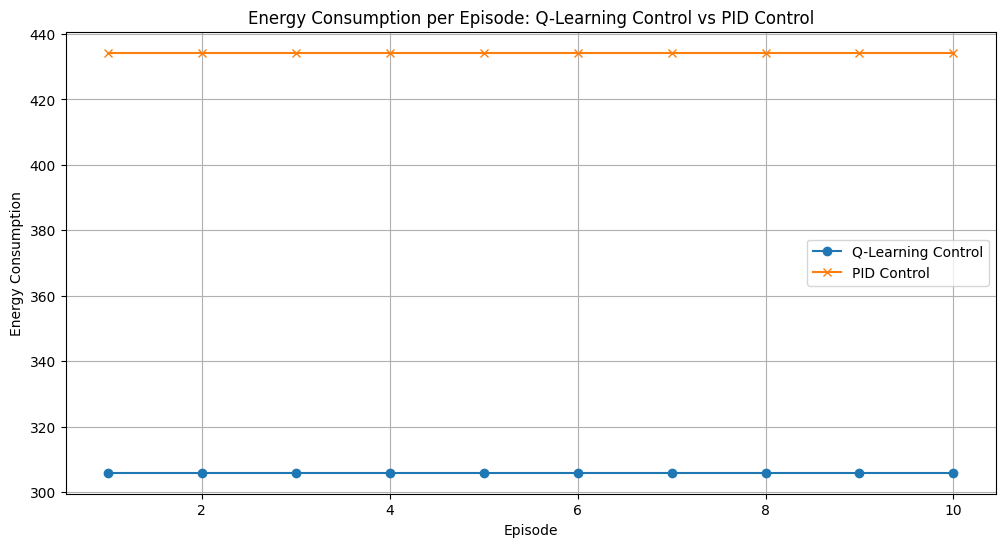

Average energy consumption Q-Learning control: 305.9206311000007
Average energy consumption PID control: 434.2789410820001
Percentage energy consumption optimization: 29.56%


In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of steps per episode for training
max_steps_per_episode = 30

# Train the agent
num_episodes = 3000
agent.train(episodes=num_episodes, max_steps_per_episode=max_steps_per_episode)

# Define the number of test episodes
num_test_episodes = 10

# Calculate energy consumption with and without control
energy_consumption_with_control = calculate_energy_consumption(test_env, test_data, agent, num_episodes=num_test_episodes)
energy_consumption_without_control = calculate_energy_consumption(test_env, test_data, num_episodes=num_test_episodes)

# Plot energy consumption
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_test_episodes + 1), energy_consumption_with_control, label='Q-Learning Control', marker='o')
plt.plot(range(1, num_test_episodes + 1), energy_consumption_without_control, label='PID Control', marker='x')
plt.xlabel('Episode')
plt.ylabel('Energy Consumption')
plt.title('Energy Consumption per Episode: Q-Learning Control vs PID Control')
plt.legend()
plt.grid(True)
plt.show()

# Calculate percentage optimization
avg_energy_with_control = np.mean(energy_consumption_with_control)
avg_energy_without_control = np.mean(energy_consumption_without_control)
percentage_optimization = ((avg_energy_without_control - avg_energy_with_control) / avg_energy_without_control) * 100

print(f"Average energy consumption Q-Learning control: {avg_energy_with_control}")
print(f"Average energy consumption PID control: {avg_energy_without_control}")
print(f"Percentage energy consumption optimization: {percentage_optimization:.2f}%")
